In [1]:
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

c:\Users\viren\miniconda3\envs\autogluon_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='../datasets/mnist_dataset',download=True,train=True,transform=transform)


test_data = datasets.MNIST(root='../datasets/mnist_dataset',download=True,train=False,transform=transform)

In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../datasets/mnist_dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../datasets/mnist_dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

Breaking down the working of convolutional layer

- Conv2d Parameters
1. In_Channels - Input Parameters
2. Out_Channels - Out Parameters
3. Kernel Size - Order of the kernel

In [6]:
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1)   # A 2 Dimensional Convolutional Layer
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)

In [7]:
for i, (X_train,y_train) in enumerate(train_data):
    break

In [8]:
print(X_train.shape)  # Converting to four dimensions to make it resemble a batch
x = X_train.view(1,1,28,28)

torch.Size([1, 28, 28])


In [9]:
x = F.relu(conv1(x))

print(x.shape)


torch.Size([1, 6, 26, 26])


In [10]:
x = F.max_pool2d(x,2,2)
print(x.shape) # Cutting the size in half , due to the pooling function

torch.Size([1, 6, 13, 13])


In [11]:
x = F.relu(conv2(x))
print(x.shape)

torch.Size([1, 16, 11, 11])


In [12]:
x = F.max_pool2d(x,2,2)
print(x.shape)

torch.Size([1, 16, 5, 5])


In [13]:
# Feeding into a flat layer
x.shape

torch.Size([1, 16, 5, 5])

In [14]:
x.view(-1,16*5*5).shape

torch.Size([1, 400])

## Model and Training

In [3]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(42)
model = ConvolutionalNetwork()
print(model)

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [17]:
total_parameters = 0
for param in model.parameters():
    total_parameters += param.numel()
    print(param.numel()) # number of elements
print(f'Total parameters: {total_parameters}')

54
6
864
16
48000
120
10080
84
840
10
Total parameters: 60074


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [19]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:  600 [  6000/60000]  loss: 0.04055628  accuracy:  78.417%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.08253483  accuracy:  85.800%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.36470482  accuracy:  88.689%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.01839540  accuracy:  90.525%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.00862627  accuracy:  91.687%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00106561  accuracy:  92.511%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.52497256  accuracy:  93.145%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.02084887  accuracy:  93.612%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.01113063  accuracy:  94.020%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.03805398  accuracy:  94.347%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01128403  accuracy:  97.833%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.05087070  accuracy:  97.908%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.00096346  accuracy:  97.900%
epoch:  1  b

In [20]:
torch.save(model.state_dict(),'MNIST_CNN.pt')

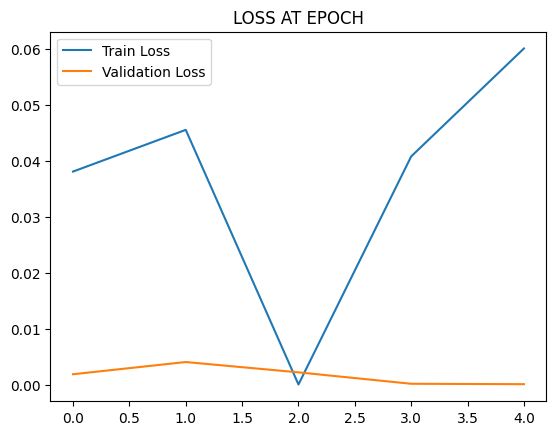

In [21]:
for loss_idx,item in enumerate(train_losses):
    train_losses[loss_idx] = item.detach().numpy().item()
plt.plot(train_losses,label='Train Loss')
plt.plot(test_losses,label='Validation Loss')
plt.title("LOSS AT EPOCH")
plt.legend()

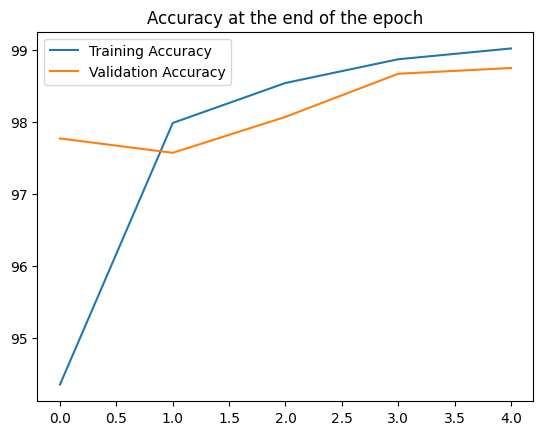

In [22]:
plt.plot([t/600 for t in train_correct],label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at the end of the epoch')
plt.legend()

In [23]:
test_load_all  = DataLoader(test_data,batch_size=10000,shuffle=False)

with torch.no_grad():
    correct = 0

    for X_test,y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        

In [24]:
correct.item()/len(test_data)*100

98.75

In [25]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
confusion_mat = confusion_matrix(predicted.view(-1), y_test.view(-1))

print(confusion_mat)


[[   0    1    2    3    4    5    6    7    8    9]]

[[ 971    0    1    0    0    2    3    1    3    0]
 [   0 1132    0    1    0    0    1    2    0    0]
 [   2    1 1024    1    1    0    3   10    3    0]
 [   0    0    2 1004    0   27    0    1    1    6]
 [   0    0    1    0  978    0    1    0    0    6]
 [   0    0    0    1    0  858    1    0    1    2]
 [   5    1    0    0    1    2  948    0    0    0]
 [   1    0    3    2    0    0    0 1008    1    3]
 [   0    1    1    1    0    0    1    1  962    2]
 [   1    0    0    0    2    3    0    5    3  990]]


The number in the image is : 7


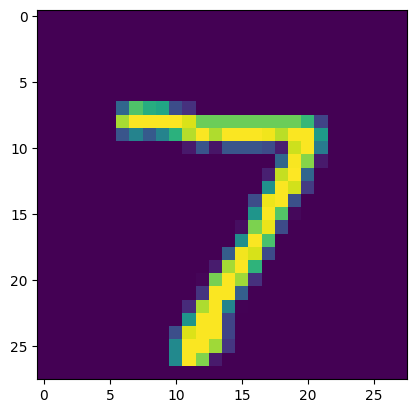

In [26]:
chosen_index = int(input("Choose a number between 1 to 10,000: "))
plt.imshow(test_data[chosen_index][0].reshape(28,28))
model.eval()
with torch.no_grad():
    new_pred = model(test_data[chosen_index][0].view(1,1,28,28))
print(f"The number in the image is : {new_pred.argmax().item()}")

In [27]:
torch.save(model,'../saved_models/mnist_torch_not_aaron.pt')

In [4]:
model2 = torch.load('../saved_models/mnist_torch_not_aaron.pt')


In [6]:
# Load the image in grayscale
img_8 = cv2.imread('../mnist_images/8/8_0008.png', cv2.IMREAD_GRAYSCALE).astype('float32')

# Normalize the image (if necessary)
# img_8 = img_8 / 255.0

print(img_8.shape)
# Reshape the image to the required input shape (1, 1, 28, 28)
img_8 = img_8.reshape(1, 1, 28, 28)

img_8_tensor = torch.tensor(img_8)

print(img_8.shape)

output = model2(img_8_tensor)

print(np.argmax(output.detach().numpy()))

(28, 28)
(1, 1, 28, 28)
8


In [9]:
model_scripted = torch.jit.script(model2) # Export to TorchScript
model_scripted.save('../saved_models/mnist_pytorch.pt') 

model3 = torch.jit.load('../saved_models/mnist_pytorch.pt')
model3.eval()


output = model3(img_8_tensor)

print(np.argmax(output.detach().numpy()))

8
